In [1]:

# Part 1: 기본 설정 및 라이브러리 임포트
import os
import glob
import numpy as np
import tensorflow as tf
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Model, regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print("TensorFlow Version:", tf.__version__)

2025-10-05 20:07:08.239816: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-05 20:07:08.271210: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-05 20:07:08.271239: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-05 20:07:08.272077: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-05 20:07:08.278549: I tensorflow/core/platform/cpu_feature_guar

TensorFlow Version: 2.15.0


In [2]:
# GPU가 사용 가능한지 확인
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2025-10-05 20:07:10.029385: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-10-05 20:07:10.063373: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-10-05 20:07:10.063426: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [3]:
# ==============================================================================
# Part 2, 3, 4: CIFAR-10 데이터 준비 (최종 오류 수정 버전)
# ==============================================================================
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tqdm import tqdm

# --- Part 2: CIFAR-10 데이터 로드 ---
print("--- Part 2: Loading CIFAR-10 Dataset ---")
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
y_train = y_train.flatten()
y_test = y_test.flatten()
cifar10_class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print("CIFAR-10 data loaded.")

# train 통계로 채널별 평균/표준편차를 계산 (CIFAR-10 기준)
MEAN = tf.constant(np.mean(x_train, axis=(0, 1, 2)), dtype=tf.float32)   # shape (3,)
STD  = tf.constant(np.std(x_train,  axis=(0, 1, 2)) + 1e-6, dtype=tf.float32)

def to_zscore(x):
    # x: [0,1] 범위
    return (x - MEAN) / STD

def from_zscore(z):
    return z * STD + MEAN



--- Part 2: Loading CIFAR-10 Dataset ---
CIFAR-10 data loaded.


2025-10-05 20:07:10.684360: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-10-05 20:07:10.684443: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-10-05 20:07:10.684461: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-10-05 20:07:10.884334: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-10-05 20:07:10.884394: I external/local_xla/xla/stream_executor

In [4]:
# --- Part 3: 데이터 증강 및 노이즈 함수 정의 (TensorFlow 버전) ---
print("\n--- Part 3: Defining Preprocessing Functions in TensorFlow ---")

# 3-1. 데이터 증강
data_augmentation_pipeline = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
])

def augment_brightness_contrast(image):
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    return image

# 3-2. 노이즈 함수 (ULTRA 버전)
def add_noise_tf(image):
    """
    입력 image: [0,1] 범위
    반환: noisy_z (z-score), cond=[t_gauss, t_sp, t_burst, c_strength]
    """
    # 표준화 도메인으로 변환
    image_z = to_zscore(image)

    noise_type = tf.random.uniform(shape=[], minval=0, maxval=3, dtype=tf.int32)

    # --- Gaussian(ULTRA: -30 ~ -10 dB) ---
    def gaussian_noise():
        snr_db = tf.random.uniform([], minval=-30.0, maxval=-10.0, dtype=tf.float32)
        sigma  = tf.pow(10.0, -snr_db / 20.0)  # Px=1 (z-score)
        noise  = tf.random.normal(shape=tf.shape(image_z), mean=0.0, stddev=sigma, dtype=tf.float32)
        noisy_z = image_z + noise                           # 학습 중 clip 금지

        # cond: [one-hot, c_strength], c = normalized log10(σ) (0.5~1.5 -> 0~1)
        log10_sigma = tf.math.log(sigma) / tf.math.log(10.0)
        c = tf.clip_by_value((log10_sigma - 0.5) / 1.0, 0.0, 1.0)
        t = tf.constant([1.0, 0.0, 0.0], tf.float32)
        cond = tf.concat([t, tf.reshape(c, [1])], axis=0)   # shape (4,)
        return noisy_z, cond

    # --- Salt & Pepper ---
    def salt_and_pepper_noise():
        amount = tf.random.uniform([], minval=0.05, maxval=0.30, dtype=tf.float32)
        u = tf.random.uniform(shape=tf.shape(image_z))
        salt   = tf.cast(u < amount * 0.5, tf.float32)
        pepper = tf.cast(u > 1.0 - amount * 0.5, tf.float32)
        noisy_z = image_z * (1.0 - salt - pepper) + salt    # 학습 중 clip 금지
        t = tf.constant([0.0, 1.0, 0.0], tf.float32)
        c = amount                                          # 자연 파라미터, [0,1]
        cond = tf.concat([t, tf.reshape(c, [1])], axis=0)
        return noisy_z, cond

    # --- Burst ---
    def burst_noise():
        h, w, cch = tf.shape(image_z)[0], tf.shape(image_z)[1], tf.shape(image_z)[2]
        size_factor = tf.random.uniform([], 0.2, 0.4)
        intensity   = tf.random.uniform([], 0.7, 1.0)
        bh = tf.cast(tf.cast(h, tf.float32) * size_factor, tf.int32)
        bw = tf.cast(tf.cast(w, tf.float32) * size_factor, tf.int32)
        sy = tf.random.uniform([], maxval=tf.maximum(1, h - bh), dtype=tf.int32)
        sx = tf.random.uniform([], maxval=tf.maximum(1, w - bw), dtype=tf.int32)

        patch = tf.random.normal([bh, bw, cch], stddev=intensity)
        noise = tf.pad(patch, [[sy, h - sy - bh], [sx, w - sx - bw], [0, 0]])
        mask  = tf.pad(tf.ones([bh, bw, cch]), [[sy, h - sy - bh], [sx, w - sx - bw], [0, 0]])
        noisy_z = image_z * (1.0 - mask) + (image_z + noise) * mask  # clip 금지

        t = tf.constant([0.0, 0.0, 1.0], tf.float32)
        c = tf.clip_by_value(size_factor * intensity, 0.0, 1.0)
        cond = tf.concat([t, tf.reshape(c, [1])], axis=0)
        return noisy_z, cond

    noisy_z, cond = tf.switch_case(
        branch_index=noise_type,
        branch_fns={0: gaussian_noise, 1: salt_and_pepper_noise, 2: burst_noise}
    )

    return noisy_z, cond




--- Part 3: Defining Preprocessing Functions in TensorFlow ---


In [5]:
# --- Part 4: 최종 데이터셋 생성 파이프라인 ---
def generate_sample_tf(clean_image, label):
    # 1) 증강 (여기까지 [0,1] 범위)
    aug = data_augmentation_pipeline(clean_image[tf.newaxis], training=True)
    aug = tf.squeeze(aug, axis=0)
    aug = augment_brightness_contrast(aug)
    clean_aug = tf.clip_by_value(aug, 0.0, 1.0)

    # 2) 노이즈 추가 (함수 내부에서 z-score 변환/노이즈 추가)
    noisy_z, cond = add_noise_tf(clean_aug)

    # 3) clean_z 준비 (학습/손실은 표준화 도메인에서)
    clean_z = to_zscore(clean_aug)

    # 반환: (입력2개: noisy_z, cond) -> (타깃2개: clean_z, label)
    return (noisy_z, cond), (clean_z, label)


In [6]:
# tf.data.Dataset 객체 생성
BATCH_SIZE = 64
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset  = tf.data.Dataset.from_tensor_slices((x_test,  y_test))

train_dataset = train_dataset.shuffle(50000).map(generate_sample_tf, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_dataset  = test_dataset.map(generate_sample_tf, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset  = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print("\n--- tf.data pipeline created successfully (ULTRA) ---")
for (noisy_z_b, cond_b), (clean_z_b, label_b) in train_dataset.take(1):
    print("Noisy (z-score) batch:", noisy_z_b.shape)  # (B,H,W,3)
    print("Cond vec batch:", cond_b.shape)            # (B,4)
    print("Clean (z-score) batch:", clean_z_b.shape)  # (B,H,W,3)
    print("Label batch:", label_b.shape)              # (B,)


--- tf.data pipeline created successfully (ULTRA) ---
Noisy (z-score) batch: (64, 32, 32, 3)
Cond vec batch: (64, 4)
Clean (z-score) batch: (64, 32, 32, 3)
Label batch: (64,)


In [7]:
# part 5: 모델 정의 (ULTRA / FiLM / residual)
from tensorflow.keras import layers, Model, regularizers
import tensorflow as tf

def build_conditional_multitask_unet(input_shape_img, input_shape_map, num_classes):
    """
    input_shape_img: (H, W, 3)  — z-score noisy 이미지
    input_shape_map: (4,)       — cond = [one-hot(type3), strength1]
    """
    # ----- FiLM blocks -----
    def film_block(x, cond, channels):
        # cond: (B, 4) → (B, 2C)
        h = layers.Dense(2*channels, activation='relu')(cond)
        h = layers.Dense(2*channels)(h)
        gamma, beta = tf.split(h, 2, axis=-1)
        gamma = tf.reshape(gamma, (-1, 1, 1, channels))
        beta  = tf.reshape(beta,  (-1, 1, 1, channels))
        # BN without affine; modulation by FiLM
        x = layers.BatchNormalization(center=False, scale=False)(x)
        return x * (1.0 + gamma) + beta

    def conv_block_cond(x, cond, nf):
        x = layers.Conv2D(nf, 3, padding='same', kernel_initializer='he_normal',
                          kernel_regularizer=regularizers.l2(1e-5))(x)
        x = layers.Activation('relu')(x)
        x = film_block(x, cond, nf)
        x = layers.Conv2D(nf, 3, padding='same', kernel_initializer='he_normal',
                          kernel_regularizer=regularizers.l2(1e-5))(x)
        x = layers.Activation('relu')(x)
        x = film_block(x, cond, nf)
        return x

    # --- 두 개의 입력 (이름 유지) ---
    image_input = layers.Input(shape=input_shape_img, name="image_input")        # (H,W,3) z-score noisy
    noise_map_input = layers.Input(shape=input_shape_map, name="noise_map_input")# (4,)  cond 벡터

    cond_in = noise_map_input  # 이름만 유지, 내용은 cond

    # Encoder
    c1 = conv_block_cond(image_input, cond_in, 32); p1 = layers.MaxPooling2D(2)(c1)
    c2 = conv_block_cond(p1, cond_in, 64); p2 = layers.MaxPooling2D(2)(c2)
    c3 = conv_block_cond(p2, cond_in, 128); p3 = layers.MaxPooling2D(2)(c3)

    # Bottleneck
    b  = conv_block_cond(p3, cond_in, 256)

    # Decoder
    d3 = layers.Conv2DTranspose(128, 2, strides=2, padding='same')(b)
    d3 = layers.Concatenate()([d3, c3])
    d3 = conv_block_cond(d3, cond_in, 128)

    d2 = layers.Conv2DTranspose(64, 2, strides=2, padding='same')(d3)
    d2 = layers.Concatenate()([d2, c2])
    d2 = conv_block_cond(d2, cond_in, 64)

    d1 = layers.Conv2DTranspose(32, 2, strides=2, padding='same')(d2)
    d1 = layers.Concatenate()([d1, c1])
    d1 = conv_block_cond(d1, cond_in, 32)

    # --- 복원 헤드: residual → 최종 복원 = noisy - residual ---
    residual_pred = layers.Conv2D(3, 1, activation='linear', name="residual_pred")(d1)
    restoration_head = layers.Subtract(name="restoration_output")([image_input, residual_pred])

    # --- 분류 헤드 (cond 정보도 함께) ---
    flat = layers.GlobalAveragePooling2D()(b)
    flat = layers.Concatenate()([flat, cond_in])
    dense1 = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(flat)
    dropout = layers.Dropout(0.5)(dense1)
    classification_head = layers.Dense(num_classes, activation='softmax', name="classification_output")(dropout)

    model = Model(inputs=[image_input, noise_map_input], outputs=[restoration_head, classification_head])
    return model



# 모델 생성 (올바른 변수 이름 사용)
num_total_classes = len(cifar10_class_names)
model = build_conditional_multitask_unet(
    input_shape_img=(32, 32, 3),
    input_shape_map=(4,),           
    num_classes=num_total_classes
)
# ------------------------------------
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 noise_map_input (InputLaye  [(None, 4)]                  0         []                            
 r)                                                                                               
                                                                                                  
 dense (Dense)               (None, 64)                   320       ['noise_map_input[0][0]']     
                                                                                                  
 image_input (InputLayer)    [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 dense_1 (Dense)             (None, 64)                   4160      ['dense[0][0]']           

In [8]:
# Part 5: 학습 (CIFAR-10 및 tf.data 파이프라인 버전)
print("\n--- Part 5: Compiling and Training the Model with tf.data ---")

# --- 5-1. 학습 파라미터 정의 (CIFAR-10 기준) ---
TRAIN_SAMPLES = 50000 # CIFAR-10 전체 학습 샘플 수
BATCH_SIZE = 64      # 데이터 생성 시 사용한 배치 크기와 동일하게 설정
STEPS_PER_EPOCH = TRAIN_SAMPLES // BATCH_SIZE # 1 에폭당 스텝 수 (나머지는 버림)

# --- 5-2. 학습률 스케줄러 및 콜백 (CIFAR-10에 맞게 수정) ---
initial_learning_rate = 1e-4
lr_schedule = ExponentialDecay(
    initial_learning_rate,
    decay_steps=STEPS_PER_EPOCH,  # <-- 1 에폭마다 학습률이 감소하도록 수정
    decay_rate=0.98,             # 200 에폭 후 약 1.7% 도달 (적절한 값)
    staircase=True
)

checkpoint_filepath = 'best_cifar10_conditional_model.keras'
# 모니터링 대상을 val_classification_output_accuracy로 변경하는 것을 추천
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath, 
    save_weights_only=False, 
    monitor='val_classification_output_accuracy', # <-- val_loss 보다 직관적
    mode='max', 
    save_best_only=True
)
early_stopping_callback = EarlyStopping(
    monitor='val_classification_output_accuracy', # <-- val_loss 보다 직관적
    patience=20, 
    verbose=1, 
    restore_best_weights=True
)

# --- 5-3. 모델 컴파일 (이전과 동일) ---
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss={
        "restoration_output": "mean_absolute_error",
        "classification_output": "sparse_categorical_crossentropy"
    },
    loss_weights={
        "restoration_output": 0.8,
        "classification_output": 0.2
    },
    metrics={"classification_output": "accuracy"}
)

# --- 5-4. 모델 학습 (tf.data.Dataset 객체 사용) ---
print("\n--- Starting model training ---")
history = model.fit(
    train_dataset, # <-- x, y 대신 train_dataset 객체 전달
    epochs=200,    # <-- 에폭 수 조정
    validation_data=test_dataset, # <-- validation_split 대신 test_dataset 전달
    callbacks=[model_checkpoint_callback, early_stopping_callback]
    # batch_size와 shuffle은 dataset 객체에 이미 적용되어 있으므로 제거
)


--- Part 5: Compiling and Training the Model with tf.data ---

--- Starting model training ---
Epoch 1/200


2025-10-05 20:07:19.443765: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8905
2025-10-05 20:07:20.611015: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f7812c84700 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-05 20:07:20.611043: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2025-10-05 20:07:20.616308: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1759662440.683996  182684 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


782/782 [==============================] - 48s 46ms/step - loss: 2.1183 - restoration_output_loss: 2.0778 - classification_output_loss: 2.0898 - classification_output_accuracy: 0.2263 - val_loss: 1.2965 - val_restoration_output_loss: 1.1049 - val_classification_output_loss: 1.8749 - val_classification_output_accuracy: 0.3136
Epoch 2/200
782/782 [==============================] - 33s 43ms/step - loss: 1.2056 - restoration_output_loss: 0.9817 - classification_output_loss: 1.9149 - classification_output_accuracy: 0.2953 - val_loss: 1.0099 - val_restoration_output_loss: 0.7717 - val_classification_output_loss: 1.7784 - val_classification_output_accuracy: 0.3472
Epoch 3/200
782/782 [==============================] - 34s 43ms/step - loss: 1.0645 - restoration_output_loss: 0.8273 - classification_output_loss: 1.8308 - classification_output_accuracy: 0.3344 - val_loss: 0.9102 - val_restoration_output_loss: 0.6621 - val_classification_output_loss: 1.7217 - val_classification_output_accuracy: 0.

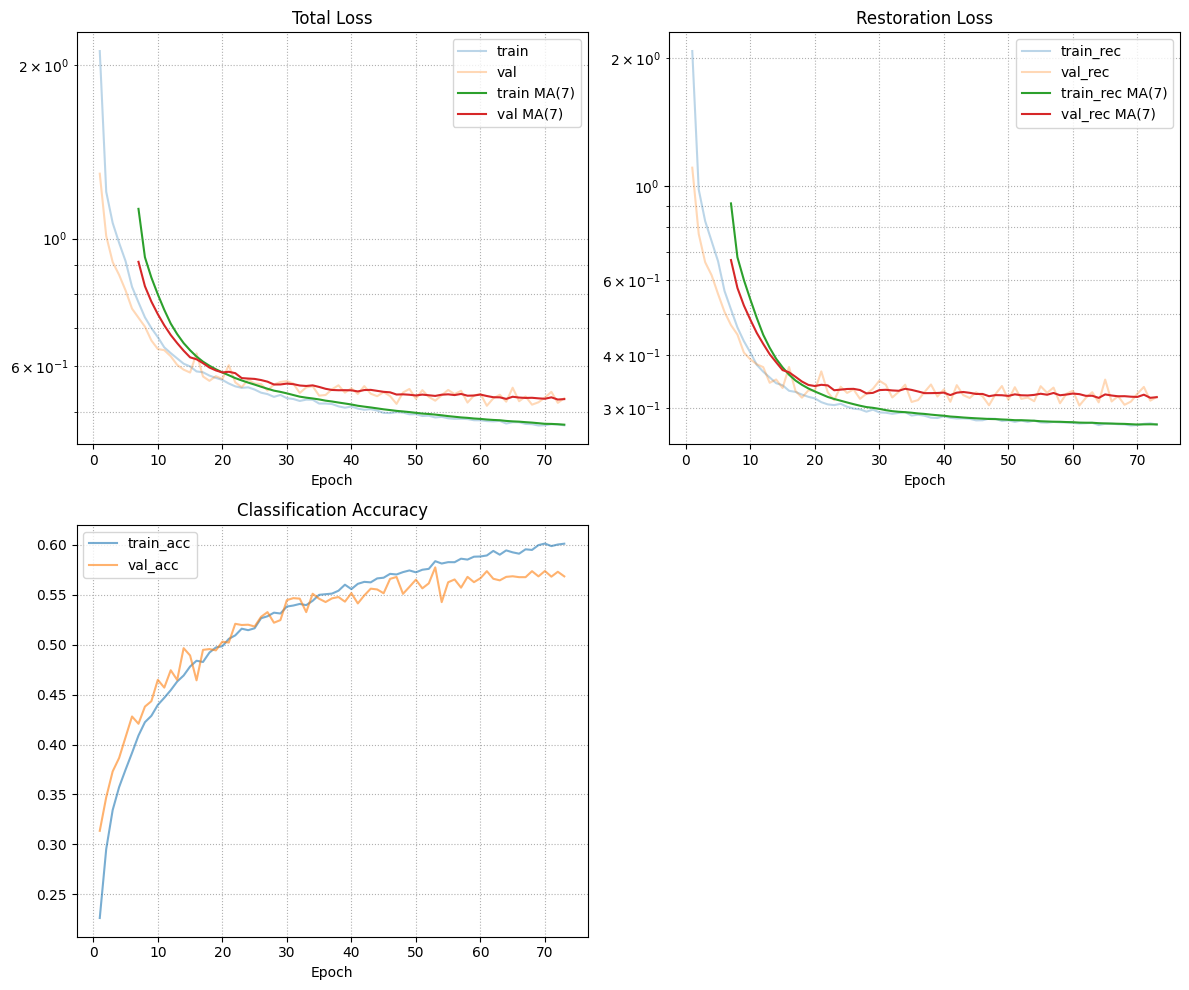

In [9]:
def plot_training_history(history, ma_window=5, logy=True):
    def moving_avg(x, k):
        if k <= 1: return np.array(x)
        k = min(k, len(x))
        return np.convolve(x, np.ones(k)/k, mode='valid')
    
    ep = np.arange(1, len(history.history['loss'])+1)
    plt.figure(figsize=(12,10))
    
    # 1) 총손실
    plt.subplot(2,2,1)
    plt.plot(ep, history.history['loss'], label='train', alpha=0.3)
    plt.plot(ep, history.history['val_loss'], label='val', alpha=0.3)
    if ma_window>1:
        plt.plot(np.arange(ma_window, len(ep)+1), moving_avg(history.history['loss'], ma_window), label=f'train MA({ma_window})')
        plt.plot(np.arange(ma_window, len(ep)+1), moving_avg(history.history['val_loss'], ma_window), label=f'val MA({ma_window})')
    if logy: plt.yscale('log')
    plt.title('Total Loss'); plt.xlabel('Epoch'); plt.legend(); plt.grid(True, which='both', ls=':')

    # 2) 복원 손실
    if 'restoration_output_loss' in history.history:
        plt.subplot(2,2,2)
        plt.plot(ep, history.history['restoration_output_loss'], label='train_rec', alpha=0.3)
        if 'val_restoration_output_loss' in history.history:
            plt.plot(ep, history.history['val_restoration_output_loss'], label='val_rec', alpha=0.3)
        if ma_window>1:
            plt.plot(np.arange(ma_window, len(ep)+1), moving_avg(history.history['restoration_output_loss'], ma_window), label=f'train_rec MA({ma_window})')
            if 'val_restoration_output_loss' in history.history:
                plt.plot(np.arange(ma_window, len(ep)+1), moving_avg(history.history['val_restoration_output_loss'], ma_window), label=f'val_rec MA({ma_window})')
        if logy: plt.yscale('log')
        plt.title('Restoration Loss'); plt.xlabel('Epoch'); plt.legend(); plt.grid(True, which='both', ls=':')

    # 3) 분류 정확도
    if 'classification_output_accuracy' in history.history:
        plt.subplot(2,2,3)
        plt.plot(ep, history.history['classification_output_accuracy'], label='train_acc', alpha=0.6)
        if 'val_classification_output_accuracy' in history.history:
            plt.plot(ep, history.history['val_classification_output_accuracy'], label='val_acc', alpha=0.6)
        plt.title('Classification Accuracy'); plt.xlabel('Epoch'); plt.legend(); plt.grid(True, which='both', ls=':')

    plt.tight_layout()
    plt.show()

# 사용
plot_training_history(history, ma_window=7, logy=True)


In [10]:
# cond = [t_gauss, t_sp, t_burst, c_strength],   c = (log10σ - 0.5) / 1.0  (→ [0,1])
def cond_to_snr_db(cond_batch):
    c = cond_batch[..., 3]
    log10_sigma = 0.5 + c
    snr_db = -20.0 * log10_sigma  # ∈ [-30, -10]
    return snr_db

SNR_BIN_NAMES = ["~ -30 dB", "~ -20 dB", "~ -10 dB"]
def snr_bin_indices(snr_db):
    # edges: (-inf, -25], (-25, -15], (-15, inf)
    bins = np.digitize(snr_db, [-25.0, -15.0])  # 0,1,2
    return np.clip(bins, 0, 2)


In [11]:
def evaluate_ultra(model, dataset, class_names, max_batches=None):
    psnr_all, ssim_all = [], []
    y_true_all, y_pred_all = [], []

    # 타입별/빈별 추적
    type_psnr = {0: [], 1: [], 2: []}   # 0:G,1:S&P,2:Burst
    type_ssim = {0: [], 1: [], 2: []}
    bin_psnr  = {0: [], 1: [], 2: []}
    bin_ssim  = {0: [], 1: [], 2: []}
    bin_acc   = {0: [], 1: [], 2: []}   # per-sample accuracy flags

    bcount = 0
    for (noisy_z_b, cond_b), (clean_z_b, label_b) in dataset:
        pred_restored_b, logits_b = model.predict([noisy_z_b, cond_b], verbose=0)
        pred_labels_b = np.argmax(logits_b, axis=-1)

        # 역정규화 + clip
        clean_b = tf.clip_by_value(from_zscore(clean_z_b), 0.0, 1.0).numpy()
        restored_b = tf.clip_by_value(from_zscore(pred_restored_b), 0.0, 1.0).numpy()

        # 배치별 PSNR/SSIM
        for i in range(restored_b.shape[0]):
            psnr = tf.image.psnr(restored_b[i:i+1], clean_b[i:i+1], max_val=1.0).numpy()[0]
            ssim = tf.image.ssim(restored_b[i:i+1], clean_b[i:i+1], max_val=1.0).numpy()[0]
            psnr_all.append(psnr); ssim_all.append(ssim)

        # 분류
        y_true_all.extend(label_b.numpy().tolist())
        y_pred_all.extend(pred_labels_b.tolist())

        # 타입/빈 기록
        type_idx = np.argmax(cond_b[:, :3].numpy(), axis=1)  # 0/1/2
        snr_vals = cond_to_snr_db(cond_b.numpy())
        bins = snr_bin_indices(snr_vals)

        for i in range(restored_b.shape[0]):
            t = int(type_idx[i]); b = int(bins[i])
            type_psnr[t].append(psnr_all[-restored_b.shape[0]+i])
            type_ssim[t].append(ssim_all[-restored_b.shape[0]+i])
            bin_psnr[b].append(psnr_all[-restored_b.shape[0]+i])
            bin_ssim[b].append(ssim_all[-restored_b.shape[0]+i])
            bin_acc[b].append(1 if y_true_all[-restored_b.shape[0]+i]==y_pred_all[-restored_b.shape[0]+i] else 0)

        bcount += 1
        if max_batches and bcount >= max_batches:
            break

    # 집계
    results = {
        "overall": {"PSNR": float(np.mean(psnr_all)), "SSIM": float(np.mean(ssim_all)),
                    "Acc": float(np.mean(np.array(y_true_all)==np.array(y_pred_all)))},
        "by_type": {
            "Gaussian": {"PSNR": np.mean(type_psnr[0]) if type_psnr[0] else np.nan,
                         "SSIM": np.mean(type_ssim[0]) if type_ssim[0] else np.nan},
            "S&P":      {"PSNR": np.mean(type_psnr[1]) if type_psnr[1] else np.nan,
                         "SSIM": np.mean(type_ssim[1]) if type_ssim[1] else np.nan},
            "Burst":    {"PSNR": np.mean(type_psnr[2]) if type_ssim[2] else np.nan,
                         "SSIM": np.mean(type_ssim[2]) if type_ssim[2] else np.nan},
        },
        "by_snr_bin": {
            SNR_BIN_NAMES[k]: {
                "PSNR": np.mean(bin_psnr[k]) if bin_psnr[k] else np.nan,
                "SSIM": np.mean(bin_ssim[k]) if bin_ssim[k] else np.nan,
                "Acc":  np.mean(bin_acc[k])  if bin_acc[k]  else np.nan
            } for k in [0,1,2]
        },
        "y_true": np.array(y_true_all),
        "y_pred": np.array(y_pred_all),
        "class_names": class_names
    }
    return results

# 사용: (validation/test셋에 대해)
metrics_val = evaluate_ultra(model, test_dataset, cifar10_class_names, max_batches=None)
print("Overall:", metrics_val["overall"])
print("By type:", metrics_val["by_type"])
print("By SNR bin:", metrics_val["by_snr_bin"])


Overall: {'PSNR': 19.412673950195312, 'SSIM': 0.5538907051086426, 'Acc': 0.5738}
By type: {'Gaussian': {'PSNR': 13.937089, 'SSIM': 0.19432579}, 'S&P': {'PSNR': 18.678503, 'SSIM': 0.5834812}, 'Burst': {'PSNR': 25.513937, 'SSIM': 0.8757404}}
By SNR bin: {'~ -30 dB': {'PSNR': 10.004148, 'SSIM': 0.04197044, 'Acc': 0.16707021791767554}, '~ -20 dB': {'PSNR': 18.609932, 'SSIM': 0.50924736, 'Acc': 0.540272614622057}, '~ -10 dB': {'PSNR': 21.555208, 'SSIM': 0.6712252, 'Acc': 0.6654991243432574}}


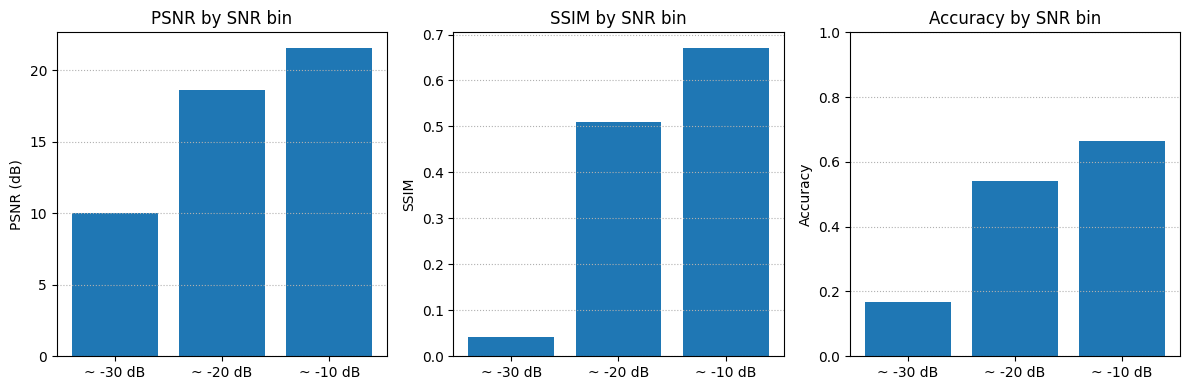

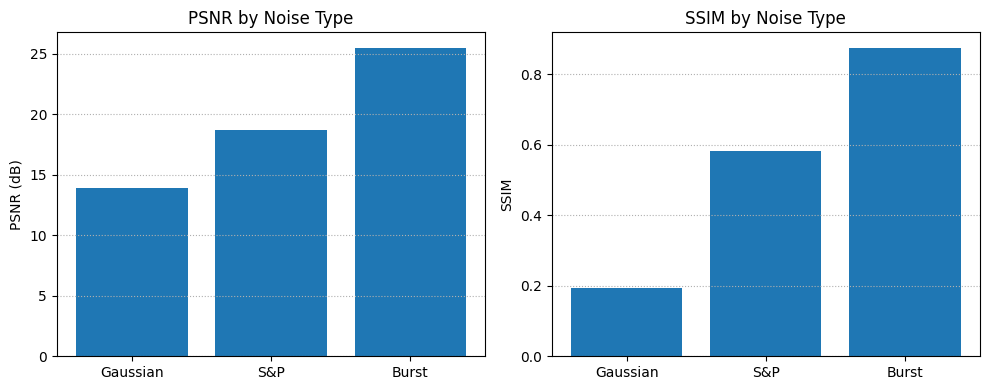

In [12]:
def plot_restoration_classification_summary(metrics):
    # SNR bin 그래프
    bins = list(metrics["by_snr_bin"].keys())
    psnr = [metrics["by_snr_bin"][b]["PSNR"] for b in bins]
    ssim = [metrics["by_snr_bin"][b]["SSIM"] for b in bins]
    acc  = [metrics["by_snr_bin"][b]["Acc"]  for b in bins]

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.bar(bins, psnr)
    plt.title("PSNR by SNR bin"); plt.ylabel("PSNR (dB)"); plt.grid(axis='y', ls=':')
    plt.subplot(1,3,2)
    plt.bar(bins, ssim)
    plt.title("SSIM by SNR bin"); plt.ylabel("SSIM"); plt.grid(axis='y', ls=':')
    plt.subplot(1,3,3)
    plt.bar(bins, acc)
    plt.title("Accuracy by SNR bin"); plt.ylabel("Accuracy"); plt.ylim(0,1); plt.grid(axis='y', ls=':')
    plt.tight_layout(); plt.show()

    # 타입별 그래프
    tnames = list(metrics["by_type"].keys())
    tpsnr = [metrics["by_type"][t]["PSNR"] for t in tnames]
    tssim = [metrics["by_type"][t]["SSIM"] for t in tnames]
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.bar(tnames, tpsnr); plt.title("PSNR by Noise Type"); plt.ylabel("PSNR (dB)"); plt.grid(axis='y', ls=':')
    plt.subplot(1,2,2)
    plt.bar(tnames, tssim); plt.title("SSIM by Noise Type"); plt.ylabel("SSIM"); plt.grid(axis='y', ls=':')
    plt.tight_layout(); plt.show()

# 사용
plot_restoration_classification_summary(metrics_val)


              precision    recall  f1-score   support

    airplane      0.672     0.639     0.655      1000
  automobile      0.681     0.675     0.678      1000
        bird      0.501     0.521     0.511      1000
         cat      0.497     0.375     0.428      1000
        deer      0.456     0.533     0.492      1000
         dog      0.546     0.465     0.502      1000
        frog      0.500     0.659     0.569      1000
       horse      0.617     0.588     0.602      1000
        ship      0.667     0.691     0.679      1000
       truck      0.630     0.592     0.611      1000

    accuracy                          0.574     10000
   macro avg      0.577     0.574     0.573     10000
weighted avg      0.577     0.574     0.573     10000



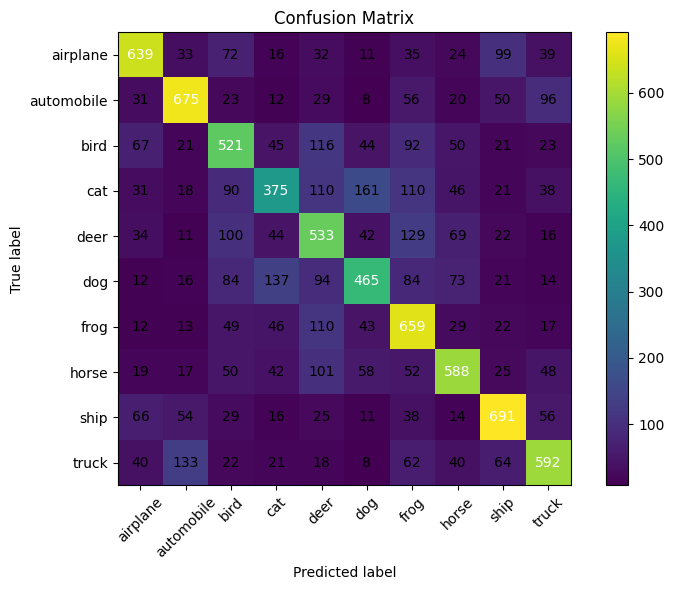

In [13]:
def plot_confusion_and_report(metrics):
    y_true = metrics["y_true"]; y_pred = metrics["y_pred"]; names = metrics["class_names"]
    cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(names)))
    print(classification_report(y_true, y_pred, target_names=names, digits=3))

    plt.figure(figsize=(8,6))
    plt.imshow(cm, interpolation='nearest')
    plt.title("Confusion Matrix"); plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45); plt.yticks(tick_marks, names)
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label'); plt.xlabel('Predicted label')
    plt.tight_layout(); plt.show()

# 사용
plot_confusion_and_report(metrics_val)


2025-10-05 20:50:19.123269: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1632128187096648950
2025-10-05 20:50:19.123352: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12309791211016236115
2025-10-05 20:50:19.123365: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12309791211016236115
2025-10-05 20:50:19.123374: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9133826535759945984
2025-10-05 20:50:19.123376: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1632128187096648950
2025-10-05 20:50:19.123382: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 16222283842109000092
2025-10-05 20:50:19.123384: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send 

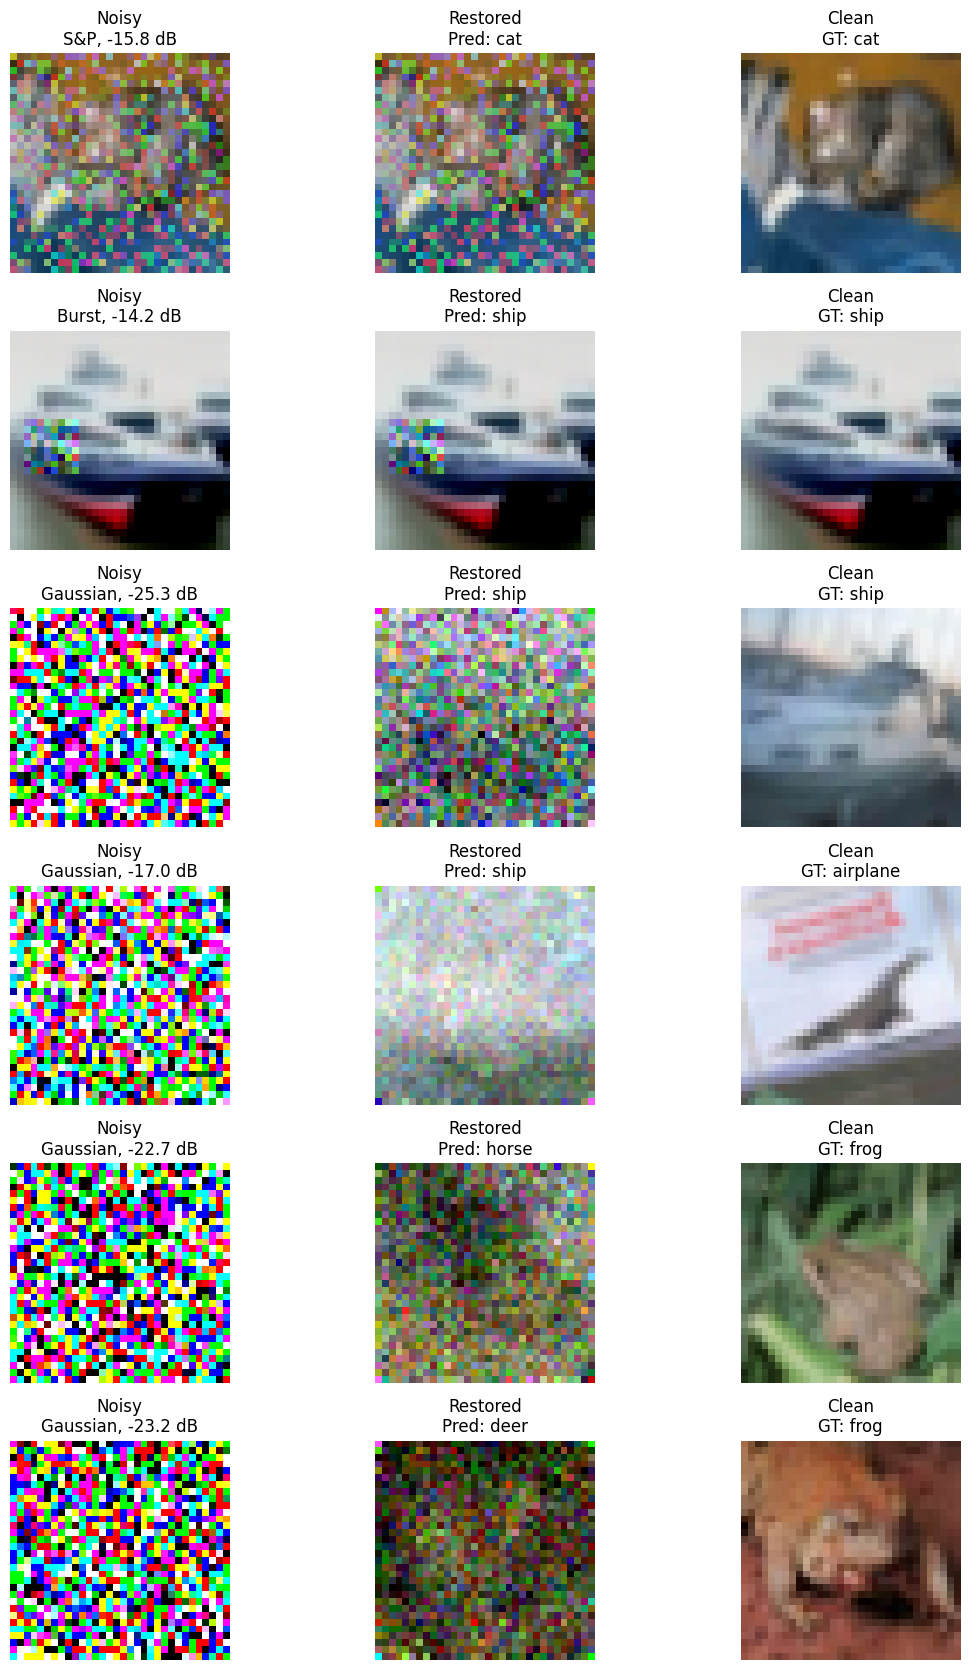

In [14]:
def visualize_ultra_results(model, dataset, num_samples=6):
    (noisy_z_b, cond_b), (clean_z_b, label_b) = next(iter(dataset.take(1)))
    pred_restored_b, pred_logits_b = model.predict([noisy_z_b, cond_b], verbose=0)
    pred_labels_b = np.argmax(pred_logits_b, axis=-1)

    plt.figure(figsize=(12, 2.8*num_samples))
    for i in range(num_samples):
        cond = cond_b[i].numpy()
        type_idx = np.argmax(cond[:3])
        tname = ["Gaussian", "S&P", "Burst"][type_idx]
        snr_db = -20.0 * (0.5 + cond[3])

        clean  = tf.clip_by_value(from_zscore(clean_z_b[i]), 0, 1).numpy()
        noisy  = tf.clip_by_value(from_zscore(noisy_z_b[i]), 0, 1).numpy()
        restor = tf.clip_by_value(from_zscore(pred_restored_b[i]), 0, 1).numpy()

        plt.subplot(num_samples, 3, 3*i+1)
        plt.imshow(noisy); plt.axis('off'); plt.title(f"Noisy\n{tname}, {snr_db:.1f} dB")

        plt.subplot(num_samples, 3, 3*i+2)
        plt.imshow(restor); plt.axis('off'); plt.title(f"Restored\nPred: {cifar10_class_names[pred_labels_b[i]]}")

        plt.subplot(num_samples, 3, 3*i+3)
        plt.imshow(clean); plt.axis('off'); plt.title(f"Clean\nGT: {cifar10_class_names[label_b[i]]}")
    plt.tight_layout(); plt.show()

# 사용
visualize_ultra_results(model, test_dataset, num_samples=6)


In [15]:
def save_extreme_samples_grid(model, dataset, filename='ultra_minus30_examples.png', max_collect=12):
    imgs = []
    for (noisy_z_b, cond_b), (clean_z_b, label_b) in dataset:
        snr = cond_to_snr_db(cond_b.numpy())
        mask = snr < -25.0  # ~ -30 dB 근처
        idxs = np.where(mask)[0][:max_collect - len(imgs)]
        if len(idxs)==0: continue
        pred_restored_b, _ = model.predict([noisy_z_b, cond_b], verbose=0)
        for i in idxs:
            clean  = tf.clip_by_value(from_zscore(clean_z_b[i]), 0, 1).numpy()
            noisy  = tf.clip_by_value(from_zscore(noisy_z_b[i]), 0, 1).numpy()
            restor = tf.clip_by_value(from_zscore(pred_restored_b[i]), 0, 1).numpy()
            imgs.extend([noisy, restor, clean])
            if len(imgs) >= max_collect: break
        if len(imgs) >= max_collect: break

    if not imgs:
        print("No ~-30dB samples found to save.")
        return

    cols = 3
    rows = int(np.ceil(len(imgs)/cols))
    plt.figure(figsize=(cols*3, rows*3))
    for i, im in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        plt.imshow(im); plt.axis('off')
        if i%3==0: plt.title("Noisy")
        elif i%3==1: plt.title("Restored")
        else: plt.title("Clean")
    plt.tight_layout(); plt.savefig(filename, dpi=200); plt.close()
    print(f"Saved grid to {filename}")

# 사용
save_extreme_samples_grid(model, test_dataset, filename='ultra_minus30_examples.png', max_collect=12)


Saved grid to ultra_minus30_examples.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.566116..2.1267862].


tf.Tensor(-1.9892052, shape=(), dtype=float32) tf.Tensor(2.1267862, shape=(), dtype=float32)


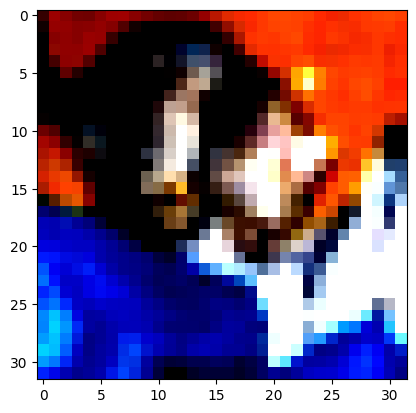

In [16]:
for (noisy_b, cond_b), (clean_b, label_b) in test_dataset.take(1):
    print(tf.reduce_min(clean_b), tf.reduce_max(clean_b))
    plt.imshow(clean_b[0].numpy())
    break